# Proportional Historical Variance
Let's compare the relative magnitudes of the seasonal component and non-seasonal component of FG_CO2 in each region. Through climate diagnostics practices, this is quite simple: find the mean seasonal cycle historically and take the standard deviation of it ($\sigma_{s}$). Then find the mean standard deviation of all the residuals ($\sigma_{r}$). Then one can simply plot the proportion of variance explained by internal variability : $\frac{\sigma_{r}}{\sigma_{s} + \sigma{r}}$

In [1]:
import glob

import numpy as np
import numpy.polynomial.polynomial as poly
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline
import cmocean.cm as cm
import cartopy.crs as ccrs
plt.style.use('ocn-clim')

import esmtools as et

# Functions

In [2]:
def load_in_filtered_data(VAR, EBU, AW=True):
    """
    Loads in the netCDF files for the ensemble mean and residuals for any inputted variable
    and returns an xarray dataset for the forced signal, residuals, and the total time series
    (simply the sum of the two previous components).
    """
    fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/' + VAR + '/' + EBU + '/filtered_output/'
    if AW == True:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-AW-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-AW-chavez-800km.nc')
    if AW == False:
        ds_forced = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-forced-signal-chavez-800km.nc')
        ds_residuals = xr.open_dataset(fileDir + EBU.lower() + '-' + VAR + '-residuals-chavez-800km.nc')
    ds_total = ds_forced + ds_residuals
    if AW == True:
        return ds_forced[VAR + '_AW'], ds_residuals[VAR + '_AW'], ds_total[VAR + '_AW']
    else:
        return ds_forced[VAR], ds_residuals[VAR], ds_total[VAR]
                         

# (0) Can we make a strong case to just investigate the natural flux of CO$_{2}$ for awhile?

A decent starting point would be to map/quantify the variability due to natural carbon and the variability due to anthropogenic carbon. What's the relative proportion that is natural?

**NOTE** : See the bar plot notebook in this folder... this first way wasn't the best way to go about doing it

In [ ]:
EBU = 'CanCS'

In [ ]:
nat_mean, nat_resid, nat_total = load_in_filtered_data('FG_ALT_CO2', EBU, AW=1)
con_mean, con_resid, con_total = load_in_filtered_data('FG_CO2', EBU, AW=1)
ant_mean, ant_resid, ant_total = load_in_filtered_data('FG_ANT_CO2', EBU, AW=1)

Let's just start with the ensemble mean (seasonal cycle) and detrend them and then take the standard deviation in 10 year chunks. We can make a stacked bar plot of the results.

In [ ]:
# Remove 4th order fits.
nat_mean = et.stats.remove_polynomial_fit(nat_mean, 4)
ant_mean = et.stats.remove_polynomial_fit(ant_mean, 4)

In [ ]:
# Find magnitude of seasonal cycle at every year
nat_s = nat_mean.groupby('time.year').std()
ant_s = ant_mean.groupby('time.year').std()

In [ ]:
fig = plt.figure(figsize=(14,3))
ax = plt.subplot(111)

p1 = plt.bar(nat_s.year, nat_s/(nat_s+ant_s)*100, 1, edgecolor='w', color='#a6cee3', label='Natural')
p2 = plt.bar(ant_s.year, ant_s/(nat_s+ant_s)*100, 1, edgecolor='w', color='#1f78b4', label='Anthropogenic',
             bottom=nat_s/(nat_s+ant_s)*100)

ax.grid('off')
ax.set_xlim([1920,2015])
ax.set_xticks(np.arange(1925, 2016, 10))
ax.set_title('Fractional Contribution of F$_{\mathrm{CO}_{2}}$ to Seasonal Variability' + '\n' + 
             '[Canary Current]')
ax.legend(loc="lower left")
plt.show()

# SAVE
#et.vis.savefig('fractional_contribution_ant_nat_seasonal_variability_' + EBU)

In [ ]:
fig = plt.figure(figsize=(14,3))
ax = plt.subplot(111)

nat_mean.plot(color='k', linewidth=2, label='natural')
ant_mean.plot(color='r', linewidth=2, label='anthropogenic')

ax.set_xlim(['1920-01', '2015-12'])
ax.set_ylabel('CO$_{2}$ Flux (mol/m$^{2}$/yr)')
ax.set_xlabel('')
ax.set_title('Ensemble Mean CO$_{2}$ Flux (Detrended)' + '\n' + '[Canary Current]')
ax.legend()

# SAVE
#et.vis.savefig('ensemble_mean_co2_flux_ant_nat_timeseries_' + EBU)

# (1) How much of the spatial variability is internal vs. seasonal?
Let's split the natural carbon flux into it's seasonal variability component and internal variability component. We can then make maps of the relative contribution of the non-seasonal component.

In [ ]:
EBU = 'CanCS'

In [ ]:
# Start by illustrating the methodology on a box-averaged situation to prove you're doing it right.
nat_mean, nat_resid, nat_total = load_in_filtered_data('FG_ALT_CO2', EBU)

# Now have a function in my package to do the whole process. Compared with
# the step-by-step and it works.
s_magnitude = nat_mean.to_dataset().apply(et.ufunc.seasonal_magnitude)
s_magnitude = s_magnitude['FG_ALT_CO2_AW']

# And the internal variability...
r_magnitude = nat_resid.std(dim='time').mean()

In [ ]:
# Compute the seasonality component for graphing purposes.
detrended = nat_mean.to_dataset().apply(et.ufunc.remove_polynomial_fit)
nat_seasonality = detrended.groupby('time.month').mean()

In [ ]:
fig = plt.figure(figsize=(5,3))
ax = plt.subplot(111)
nat_seasonality['FG_ALT_CO2_AW'].plot(color='k')
ax.set(title=EBU + ' F$_{\mathrm{Nat}}$ Seasonal Cycle',
       xticks=np.arange(1,13,1), ylabel='Natural CO$_{2}$ Flux')
ax.text(1, 1, '$\sigma$ = ' + str(s_magnitude.values.round(3)), size='x-large')

#et.vis.savefig(EBU + '_Seasonal_Cycle')

In [ ]:
fig = plt.figure(figsize=(12,3))
ax = plt.subplot(111)
for i in np.arange(0, 34, 1):
    nat_resid[i].plot(color='#D3D3D3', linewidth=2)
ax.set(xlim=['1920','2015'], title=EBU + ' F$_{\mathrm{Nat}}$ Residuals',
       ylabel='Natural CO$_{2}$ Flux', xlabel='')
ax.text('1925', 4, '$\sigma$ = ' + str(r_magnitude.values.round(3)),
        size='x-large')
#et.vis.savefig(EBU + '_Residual_Spread')

In [ ]:
non_seasonal_variability = r_magnitude / (s_magnitude + r_magnitude)
print("The non-seasonal component of variability is : " + str(non_seasonal_variability.values.round(3)))

# (2) What do these two analyses look like on a grid cell basis?

### Computing the Relative Magnitudes

In [ ]:
EBU = 'CalCS'

In [ ]:
# Bring down full grid
nat_mean, nat_resid, nat_total = load_in_filtered_data('FG_ALT_CO2', EBU, AW=False)

In [ ]:
# Compute the seasonal magnitude component
stacked = nat_mean.stack(allpoints=['nlat', 'nlon'])
operation = stacked.groupby('allpoints', squeeze=False).apply(et.ufunc.seasonal_magnitude)
s_magnitude = operation.unstack('allpoints')

In [ ]:
# Compute the mean internal magnitude component
r_magnitude = nat_resid.std(dim='time').mean(dim='ensemble')

In [ ]:
# Create relative contribution.
relative_internal = (r_magnitude / (r_magnitude + s_magnitude)) * 100

In [ ]:
# Data
lat = relative_internal['TLAT'].values
lon = relative_internal['TLONG'].values
data = relative_internal.to_masked_array()

# Set Extent
x0,x1,y0,y1 = et.ebus.visual_bounds(EBU, std_lon=True)

# Plot
f, ax = et.vis.make_cartopy(grid_lines=False, projection=ccrs.Mercator(),
                     land_color='#d3d3d3', frameon=False)
plt.pcolor(lon-0.5, lat, data, transform=ccrs.PlateCarree(),
           edgecolor='w', vmin=0, vmax=100,
           cmap=et.vis.discrete_cmap(10, 'BrBG_r'))
ax.set_extent([x0,x1,y0,y1])
cb = plt.colorbar(ax=ax, ticks=[0,25,50,75,100], orientation='horizontal',
                 fraction=0.045, pad=0.04, label='Non-Seasonal Variability [%]')
ax.set_title('Fraction of F$_{\mathrm{Nat}}$ Due to Internal Variability',
             fontsize='xx-large')


# Save Plot
#et.vis.savefig('fractional_internal_variability_FG_ALT_CO2' + EBU)

# (3) What does this look like when we involve the trend?
Can we make some plots comparing the long-term anthropogenic trend?

** Note **: Will do this once I get my hands on the FG_ANT_CO2 output.

In [23]:
EBU = 'CanCS'

In [24]:
nat_mean, nat_resid, nat_total = load_in_filtered_data('FG_ALT_CO2', EBU, AW=False)
ant_mean, ant_resid, ant_total = load_in_filtered_data('FG_ANT_CO2', EBU, AW=False)

In [25]:
# Compute the seasonal magnitude component.
s_magnitude = nat_mean.stack(allpoints=['nlat','nlon']) \
                      .groupby('allpoints', squeeze=False) \
                      .apply(et.ufunc.seasonal_magnitude) \
                      .unstack('allpoints')

In [26]:
# Compute the magnitude from internal variability.
r_magnitude = nat_resid.std(dim='time').mean(dim='ensemble')

In [35]:
# Compute the magnitude of the trend.
t_magnitude = ant_mean.stack(allpoints=['nlat', 'nlon']) \
                      .groupby('allpoints', squeeze=True) \
                      .apply(et.ufunc.compute_slope) \
                      .unstack('allpoints')
t_magnitude = t_magnitude * ant_mean.shape[0]

PLOT!

In [36]:
import cartopy.feature as cfeature
def make_subplot_cartopy(r,c,i, projection=ccrs.Robinson(), land_color='k', grid_color='#D3D3D3',
                 grid_lines=True, figsize=(12,8), frameon=True):
    ax = plt.subplot(r,c,i, projection=projection)
    if grid_lines == True:
        ax.gridlines(draw_labels=False, color=grid_color)
    ax.add_feature(cfeature.LAND, facecolor=land_color)
    if frameon == False:
        ax.outline_patch.set_edgecolor('white')
    return ax

In [37]:
def pcolor_subplot(ax, lon, lat, data, vmin=0, vmax=3, edgecolor='w', cmap=et.vis.discrete_cmap(10,cm.dense)):
    p = ax.pcolor(lon, lat, data.to_masked_array(), transform=ccrs.PlateCarree(),
               edgecolor=edgecolor, vmin=vmin, vmax=vmax, cmap=cmap)
    return p

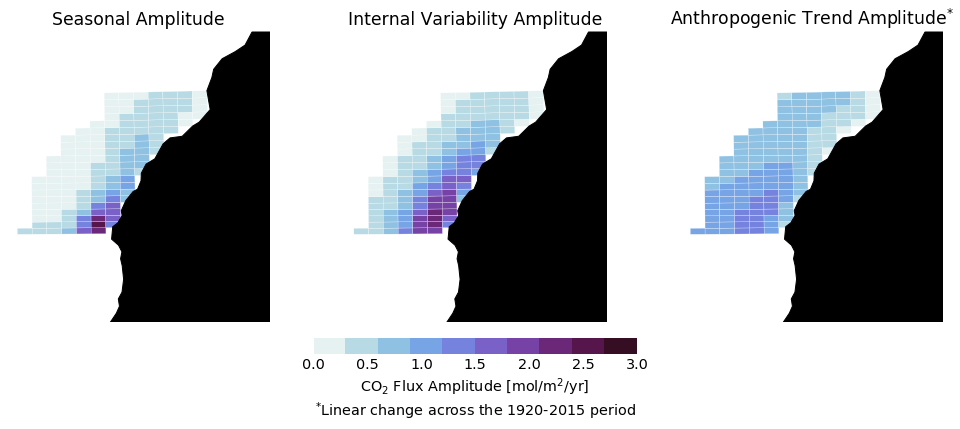

In [38]:
lon = s_magnitude.TLONG - 0.5
lat = s_magnitude.TLAT
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), subplot_kw=dict(projection=ccrs.Mercator()))

# SEASONAL AMPLITUDE
pcolor_subplot(axes[0],lon,lat,s_magnitude)
x0,x1,y0,y1 = et.ebus.visual_bounds(EBU)
axes[0].set_extent([x0,x1,y0,y1])
axes[0].add_feature(cfeature.LAND, facecolor='k')
axes[0].outline_patch.set_edgecolor('white')
axes[0].set(title='Seasonal Amplitude')

# INTERNAL AMPLITUDE
pcolor_subplot(axes[1],lon,lat,r_magnitude)
x0,x1,y0,y1 = et.ebus.visual_bounds(EBU)
axes[1].set_extent([x0,x1,y0,y1])
axes[1].add_feature(cfeature.LAND, facecolor='k')
axes[1].outline_patch.set_edgecolor('white')
axes[1].set(title='Internal Variability Amplitude')

# TREND AMPLITUDE
p = pcolor_subplot(axes[2],lon,lat,np.abs(t_magnitude.squeeze()))
x0,x1,y0,y1 = et.ebus.visual_bounds(EBU)
axes[2].set_extent([x0,x1,y0,y1])
axes[2].add_feature(cfeature.LAND, facecolor='k')
axes[2].outline_patch.set_edgecolor('white')
axes[2].set(title='Anthropogenic Trend Amplitude$^{*}$')

# COLORBAR
fig.tight_layout()
cb = fig.colorbar(p, ax=axes.ravel().tolist(), orientation='horizontal',
             fraction=0.05, pad=0.05)
cb.set_label('CO$_{2}$ Flux Amplitude [mol/m$^{2}$/yr]' + '\n' +
             '$^{*}$Linear change across the 1920-2015 period')

# SAVE
#et.vis.savefig(EBU + '_seasonal_vs_internal_vs_trend')

# (3b) What is the signal to noise historically?

In [155]:
EBU = 'HumCS'

In [156]:
nat_mean, nat_resid, nat_total = load_in_filtered_data('FG_ALT_CO2', EBU, AW=False)
ant_mean, ant_resid, ant_total = load_in_filtered_data('FG_ANT_CO2', EBU, AW=False)

In [157]:
# Compute the magnitude from internal variability.
nat_internal = nat_resid.std(dim='time').mean(dim='ensemble')
# Compute the magnitude of the trend.
ant_trend = ant_mean.stack(allpoints=['nlat', 'nlon']) \
                      .groupby('allpoints', squeeze=True) \
                      .apply(et.ufunc.compute_slope) \
                      .unstack('allpoints')
ant_trend = ant_trend * ant_mean.shape[0]

In [158]:
SNR = ant_trend / nat_internal
# Absolute value
SNR = np.fabs(SNR)

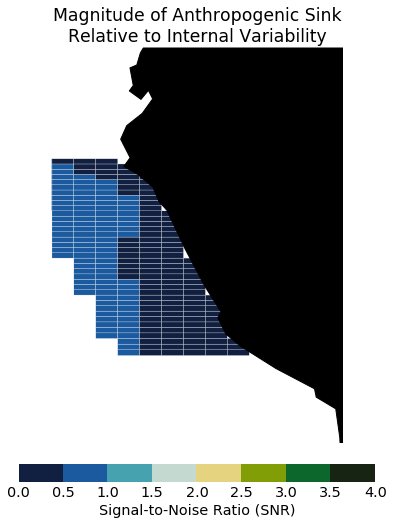

In [159]:
# Set up projection
f, ax = et.vis.make_cartopy(projection=ccrs.Mercator(), grid_lines=False,
                            frameon=False)
x0,x1,y0,y1 = et.ebus.visual_bounds(EBU)
ax.set_extent([x0,x1,y0,y1])

# PCOLOR
plt.pcolor(SNR.TLONG-0.5, SNR.TLAT, SNR.to_masked_array(), 
           transform=ccrs.PlateCarree(), edgecolor='w',
           vmin=0, vmax=4, cmap=et.vis.discrete_cmap(8, cm.delta))

# COLORBAR
cb = plt.colorbar(orientation='horizontal', pad=0.05, fraction=0.041)
cb.set_label('Signal-to-Noise Ratio (SNR)')
ax.set_title('Magnitude of Anthropogenic Sink' + '\n' + 'Relative to Internal Variability')

# (4) How does the non-seasonal variability look relative to large ocean basins?

Nikki wants to make a point that these systems are anomalously high in internal variability. Going to try two approaches to this:

1. Make a global map of the non-seasonal variability and see if these pop out.
2. Use REGION_MASK to compute these on an area-weighted scale and then make bar plots.

### Global Map Approach
Note that I applied the seasonal_magnitude function to the entire global grid of ensemble mean FG_ALT_CO2. I just removed those cells to keep this notebook clean, since I saved the output to a netcdf.

# (4b) Load in already processed files

In [3]:
# Contemporary CO2 Flux
fileDir = '/glade/p/work/rbrady/EBUS_BGC_Variability/FG_CO2/global/FG_CO2_seasonal_internal_global_magnitudes.nc'
ds = xr.open_dataset(fileDir)

### Conventional Flux Relative Magnitude

In [5]:
ds['relative_internal'] = (ds['r_magnitude'] / (ds['s_magnitude'] + ds['r_magnitude']))*100

In [6]:
lon, lat, data = et.vis.deseam(ds['TLONG'], ds['TLAT'], ds['relative_internal'])

In [7]:
EBUS = ['CalCS', 'HumCS', 'CanCS', 'BenCS']

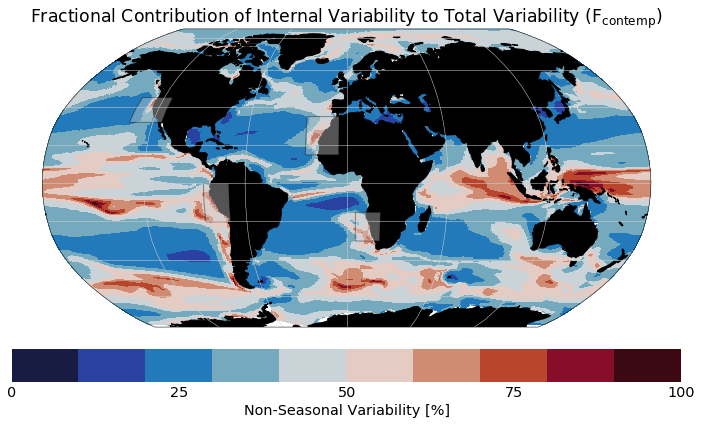

In [8]:
f, ax = et.vis.make_cartopy()
m = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(),
              vmin=0, vmax=100, cmap=et.vis.discrete_cmap(10, cm.balance))
cb = plt.colorbar(m, ax=ax, orientation='horizontal', pad=0.05,
                  ticks=[0,25,50,75,100])
ax.set_title('Fractional Contribution of Internal Variability to Total Variability (F$_{\mathrm{contemp}}$)')
cb.set_label('Non-Seasonal Variability [%]')

for EBC in EBUS:
    x0, x1, y0, y1 = et.ebus.visual_bounds(EBC, std_lon=True)
    et.vis.add_box(ax, x0, x1, y0, y1,
                   facecolor='#d3d3d3', edgecolor='k',
                   linewidth=2, alpha=0.4)
    


### Absolute Seasonal Magnitude

In [14]:
lon, lat, data = et.vis.deseam(ds['TLONG'], ds['TLAT'], ds['s_magnitude'])

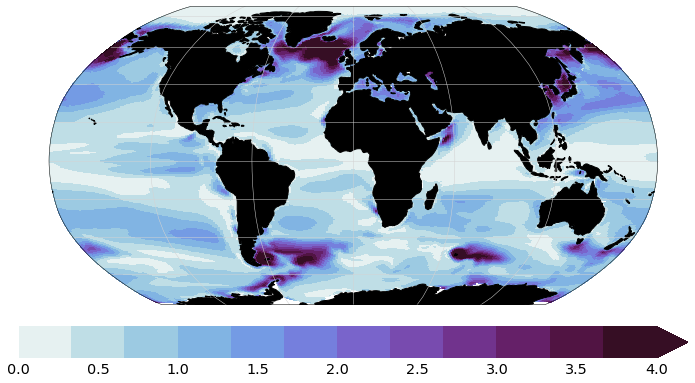

In [15]:
f, ax = et.vis.make_cartopy()
m = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(),
                  vmin=0, vmax=4, cmap=et.vis.discrete_cmap(12, cm.dense))
cb = plt.colorbar(m, ax=ax, orientation='horizontal', pad=0.05,
                  extend='max')
#ax.set_title('Fractional Contribution of Internal Variability to Total Variability (F$_{\mathrm{contemp}}$)')
#cb.set_label('Non-Seasonal Variability [%]')

### Absolute Internal Magnitude

In [16]:
lon, lat, data = et.vis.deseam(ds['TLONG'], ds['TLAT'], ds['r_magnitude'])

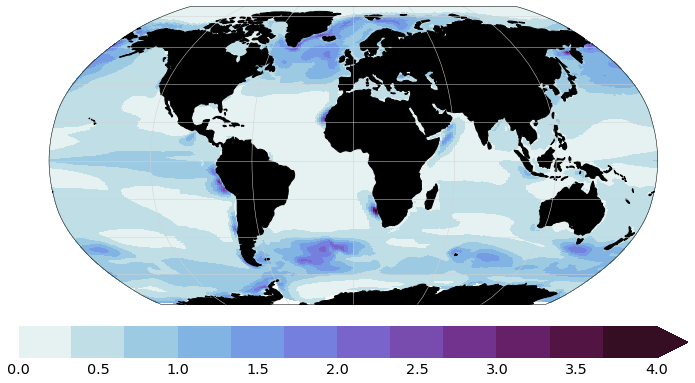

In [17]:
f, ax = et.vis.make_cartopy()
m = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(),
                  vmin=0, vmax=4, cmap=et.vis.discrete_cmap(12, cm.dense))
cb = plt.colorbar(m, ax=ax, orientation='horizontal', pad=0.05,
                  extend='max')